In [1]:
from NewLibraryENGcopia import *

In [2]:
input_path='/Users/Gaia_1/Desktop/allh5filestutto/2019-01-23T11-41-41Pop1 healthy cortical .h5'
name_data = input_path.split("/")[-1]
#file reading:
print('File Reading...')
data = h5py.File(input_path,'r')
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print('data shape: ',readings.shape)
prova=readings.drop([b'Ref'],axis=1)
#prova=prova.iloc[0:750500, :]
#prova=prova.iloc[:, :15]
ref=readings[b'Ref']
#ref=ref[0:750500]


File Reading...
data shape:  (5020000, 60)


example=b'48'
plt.figure(figsize=(30, 15))
plt.plot(prova[example])
plt.plot(readings[b'Ref'])

In [3]:
freqs, spectrogram = signal.welch(readings[b'Ref'].values, fs=10000, nfft=1024)
noise_freq = freqs[spectrogram.argmax()]
Q = 30
b, a = scipy.signal.iirnotch(noise_freq, Q, fs)
Q = 60
b_2, a_2 = scipy.signal.iirnotch(2*noise_freq, Q, fs)
channel = readings[b'Ref'].values
pre_filtered_ref = scipy.signal.filtfilt(b, a, channel)
pre_filtered_ref = scipy.signal.filtfilt(b_2, a_2, pre_filtered_ref) 



plt.figure(figsize=(20,10))
plt.plot(freqs,spectrogram)
plt.savefig('reference_noise.jpg')

In [4]:
noise_freq

458.984375

plt.figure(figsize=(20, 10))
plt.plot(ref)
plt.plot(pre_filtered_ref)
plt.axis([3180000,3185000,-100,100])
#plt.savefig('reference_before_after_zoomed.jpg')

In [5]:
ref=pre_filtered_ref

In [6]:
#filtering:
prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
print('Data Filtering:')
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
prova=filt_prova


Data Filtering:


  0%|          | 0/59 [00:00<?, ?it/s]

example=b'47'
plt.figure(figsize=(20, 10))
plt.plot(readings[example])
plt.plot(prova[example])
plt.savefig('channel_before_after.jpg')

In [8]:
#detection:
all_ind=[]
print('Spike Detection: ')
for i,electrode in enumerate(tqdm(prova.columns)):
    channel=prova[electrode]
    #ind=windowed_spike_detection(channel)
    ind=spike_detection(channel)
    all_ind.append(ind)
    

Spike Detection: 


  0%|          | 0/59 [00:00<?, ?it/s]

47633  spikes detected;   firing rate: 94.89 Hz
48501  spikes detected;   firing rate: 96.62 Hz
49000  spikes detected;   firing rate: 97.61 Hz
48268  spikes detected;   firing rate: 96.15 Hz
48331  spikes detected;   firing rate: 96.28 Hz
32485  spikes detected;   firing rate: 64.71 Hz
31092  spikes detected;   firing rate: 61.94 Hz
37269  spikes detected;   firing rate: 74.24 Hz
33260  spikes detected;   firing rate: 66.25 Hz
33835  spikes detected;   firing rate: 67.40 Hz
31732  spikes detected;   firing rate: 63.21 Hz
30460  spikes detected;   firing rate: 60.68 Hz
27769  spikes detected;   firing rate: 55.32 Hz
27524  spikes detected;   firing rate: 54.83 Hz
22905  spikes detected;   firing rate: 45.63 Hz
24931  spikes detected;   firing rate: 49.66 Hz
26554  spikes detected;   firing rate: 52.90 Hz
29138  spikes detected;   firing rate: 58.04 Hz
28777  spikes detected;   firing rate: 57.32 Hz
27385  spikes detected;   firing rate: 54.55 Hz
33617  spikes detected;   firing rate: 6

plott=prova[example]
indss=all_ind[0]
plt.figure(figsize=(20, 10))
plt.plot(plott, label='Signal Data')
plt.scatter(indss, [plott[i] for i in indss], c='red', marker='o', label='Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([4180000,4223000,-800,300])
#plt.savefig('spikes1.jpg')
plt.show()

plott=prova[example]
window=plott[0:1000000]
threshold=scipy.stats.median_abs_deviation(window,scale='normal')
indss=all_ind[0]
plt.figure(figsize=(20, 10))
plt.plot(plott, label='Signal Data')
plt.scatter(indss, [plott[i] for i in indss], c='red', marker='o', label='Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.axhline(y=-3*threshold, color='r', linestyle='--', label='3*MAD')
plt.axhline(y=-4*threshold, color='g', linestyle='--', label='4*MAD')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
plt.axis([0,1000000,-1000,600])
plt.savefig('spikes_healthy_1min.jpg')
plt.show()

plott=prova[example]
window=plott[0:1000000]
threshold=scipy.stats.median_abs_deviation(window,scale='normal')
indss=all_ind[0]
plt.figure(figsize=(20, 10))
plt.plot(plott, label='Signal Data')
plt.scatter(indss, [plott[i] for i in indss], c='red', marker='o', label='Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.axhline(y=-3*threshold, color='r', linestyle='--', label='3*MAD')
plt.axhline(y=-4*threshold, color='g', linestyle='--', label='4*MAD')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
plt.axis([0,10000,-1000,420])
#plt.savefig('spikes_healthy_1min.jpg')
plt.show()

In [103]:
def this_cut_all(alls,data):
    pre = 0.001
    post = 0.002
    fs=10000
    prima = int(pre*fs)
    dopo = int(post*fs)
    lunghezza_indici = len(alls)
    cut= np.empty([lunghezza_indici, prima+dopo])
    dim = data.shape[0]
    k=0
    #coeff=1.5
    signal_std=np.std(data)
    signal_mean=np.mean(data)
    standard_threshold=signal_std
    for i in alls:
        if (i-prima >= 0) and (i+dopo <= dim):
            spike= data[(int(i)-prima):(int(i)+dopo)].squeeze()
            
            cut[k,:] = spike
            k+=1
    standards=np.std(cut,axis=1)
    means=np.mean(cut,axis=1)
    
    print('mean',signal_mean)
    
    
    standard_mean=signal_mean

    thr1=3*standard_threshold
    thr2=3*standard_mean
    
    indices=np.where((standards<thr1)&(means<thr2))[0]
    to_throw=np.where((standards>=thr1)&(means>=thr2))[0]
    buttati=cut[to_throw]

    filtered_alls = np.array(alls)[indices]
    filtered_cut=cut[indices]
    
    spike_means=np.mean(filtered_cut,axis=1,keepdims=True)
    spike_stds=np.std(filtered_cut,axis=1,keepdims=True)

    zero_std_indices = np.where(spike_stds == 0)
    spike_stds[zero_std_indices] = 1

    standardized_cuts=(filtered_cut-spike_means)/spike_stds
    
    firing_rate=len(indices)*10000/len(data)
    print(len(alls)-len(indices),' spikes removed;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return standardized_cuts,filtered_alls#,buttati


In [104]:
#spike extraction:
cut_outs=[]
all_new=[]
print('Spike extraction: ')
for i,electrode in enumerate(tqdm(prova.columns)):
    ind=all_ind[i]
    channel=prova[electrode]
    cut_outs1,all_new1=this_cut_all(ind,channel)
    cut_outs.append(cut_outs1)
    all_new.append(all_new1)    


Spike extraction: 


  0%|          | 0/59 [00:00<?, ?it/s]

mean 5.394878528688054e-05
29448  spikes removed;   firing rate: 36.23 Hz
mean 7.88143321864134e-05
30076  spikes removed;   firing rate: 36.70 Hz
mean 2.843732996560555e-05
30478  spikes removed;   firing rate: 36.90 Hz
mean 0.00010783623611780535
29847  spikes removed;   firing rate: 36.70 Hz
mean 5.513704214240832e-05
29766  spikes removed;   firing rate: 36.98 Hz
mean 0.00012554609534277318
21774  spikes removed;   firing rate: 21.34 Hz
mean 0.00013075888857621038
21972  spikes removed;   firing rate: 18.17 Hz
mean 7.536108864746984e-07
24497  spikes removed;   firing rate: 25.44 Hz
mean 0.00013825926186632943
23098  spikes removed;   firing rate: 20.24 Hz
mean 0.00016890318102903354
22482  spikes removed;   firing rate: 22.62 Hz
mean 4.682912112353113e-05
23413  spikes removed;   firing rate: 16.57 Hz
mean 6.359943545057967e-05
22461  spikes removed;   firing rate: 15.93 Hz
mean 6.822537167250559e-05
20554  spikes removed;   firing rate: 14.37 Hz
mean 5.753094097638012e-05
20244  

In [107]:
def clus(cut,spike_list,data):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import silhouette_score
    import numpy as np
    scale = StandardScaler()
    estratti_norm = scale.fit_transform(cut)
    print('\n______________________________________________________________________________________________________________')
    print('Total spikes: ', estratti_norm.shape[0])
    n_comp=3
    pca = PCA(n_components=n_comp)
    transformed = pca.fit_transform(estratti_norm)
    spike_list=np.array(spike_list)
    kmeans_score=[]
    final_data=[]
    final_firing=[]
    for n in range (2,4):
        model = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=400, tol=0.25, verbose=0, random_state=None, copy_x=True,  algorithm='lloyd')
        labels = model.fit_predict(transformed)
        silhouette_avg = silhouette_score(transformed, labels)
        kmeans_score.append(silhouette_avg)
    top_clusters_kmeans = kmeans_score.index(max(kmeans_score))+2
    if max(kmeans_score)>=0.4:
        print("\n\n\033[1;31;47mBest cluster in the range 1 to 3: ",top_clusters_kmeans,", with a silhouette score of: ",max(kmeans_score), "\u001b[0m  \n\n")
        model = KMeans(n_clusters=top_clusters_kmeans,  init='k-means++', n_init=10, max_iter=400, tol=0.25, verbose=0, random_state=None, copy_x=True,  algorithm='lloyd')
        labels = model.fit_predict(transformed)
    else:
        print('Clustering algorithm detected only one cluster')
        labels=np.zeros(len(spike_list),dtype=int)
    unique_labels=np.unique(labels)
    firings=np.zeros(len(unique_labels))
    color=[]
    for i in labels:
        color.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    for i,cluster_label in enumerate(unique_labels):
        cluster_data=cut[labels==cluster_label]
        mean_wave=np.mean(cluster_data, axis=0)
        std_wave=np.std(cluster_data, axis=0)
        #distances=np.abs(cluster_data - mean_wave)
        #distance_threshold=2*std_wave
        #indices_to_keep=np.all(distances<=distance_threshold,axis=1)
        #filtered_cluster_data=cluster_data[indices_to_keep]
        filtered_cluster_data=cluster_data
        plotting_data=filtered_cluster_data.transpose()
        firings[i]=len(filtered_cluster_data)*10000/len(data)
        fig = plt.figure(figsize=(15,20))
        plt.subplot(3,1,i+1)
        plt.plot(plotting_data,alpha=0.5)
        plt.title(f'Cluster {i} \n numerosity: {len(filtered_cluster_data)}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Signal Amplitude')
        mean_wave = np.mean(filtered_cluster_data, axis=0)
        std_wave = np.std(filtered_cluster_data, axis=0)
        plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
        plt.legend(loc='lower right')
        plt.show()
        ul=spike_list[labels==i]
        ull=ul
        #ull=ul[indices_to_keep]
        final_data.append(ull)
        final_firing.append(firings)
        fig = plt.figure(figsize=(15,20))
        plt.subplot(3, 1, i + 1)
        plt.hist(np.diff(ull), bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')
        plt.title(f'ISI: Cluster {i}, \n firing rate: {format(len(final_data[i])*10000/len(data), ".2f")} Hz')
        plt.show()
        
    return final_data, final_firing



______________________________________________________________________________________________________________
Total spikes:  15760
Clustering algorithm detected only one cluster


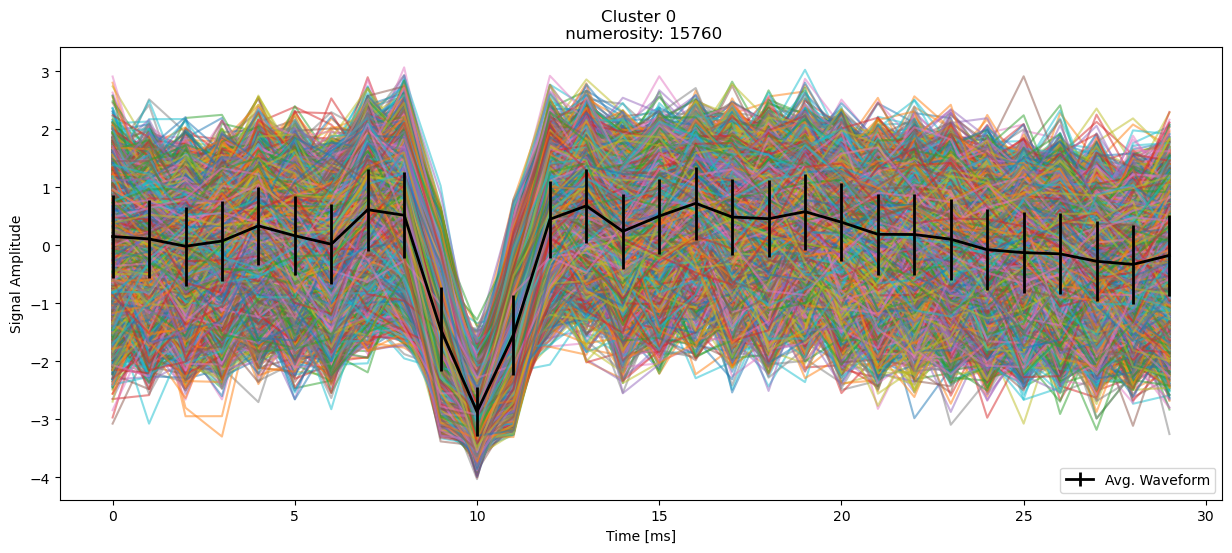

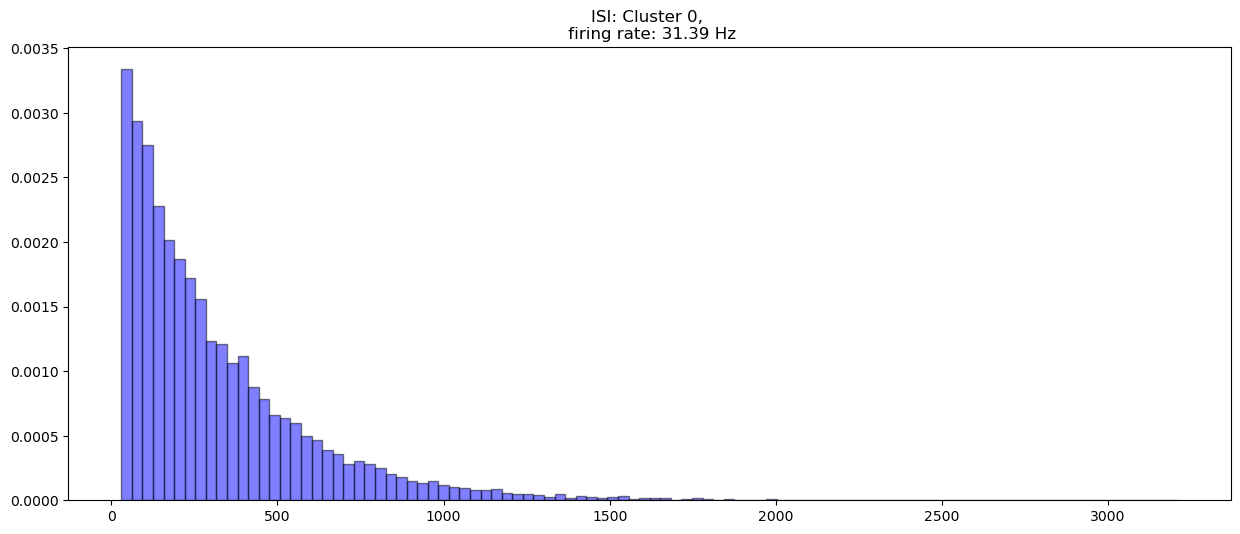

In [110]:
channel=30
channel_clusters1,final_firing1=clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel])


In [ ]:
# Clustering:
final_data=[]
final_firing=[]
final_firing.append(name_data)
print('Clustering: ')
for channel in (tqdm(range(len(cut_outs)))):
    channel_clusters1,final_firing1=clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel])
    final_data.append(channel_clusters1)
    final_firing.append(final_firing1)


In [12]:
cut_outs[0]

array([[ 0.97328207,  0.85296199,  0.27613214, ..., -0.23672171,
        -0.80963115, -0.72345262],
       [ 0.0366134 ,  0.06333744, -0.19948683, ...,  0.08610034,
        -0.32648748, -0.29663796],
       [ 0.29767148,  0.34697627, -0.08546567, ...,  0.02863008,
         0.46676567,  0.8981485 ],
       ...,
       [ 0.82100068, -0.01201898, -0.27557054, ..., -0.17374621,
        -0.87882657, -1.40539828],
       [ 0.11771886,  0.87151361,  1.24666731, ...,  0.27770922,
        -1.21170611, -1.0890842 ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [93]:
example=b'47'
channel=prova[example]
cut_outs1,all_new1,buttati=this_cut_all(all_ind[0],channel)
#cut_outs2,all_new2=this_cut_all_noselection(all_ind[0],channel)

mean 5.394878528688054e-05
29448  spikes removed;   firing rate: 36.23 Hz


/var/folders/d6/n7zzsskd0jv11v_qxbdvkkf40000gn/T/ipykernel_4853/1784426269.py:42: RuntimeWarning: invalid value encountered in divide
  standardized_cuts=(filtered_cut-spike_means)/spike_stds


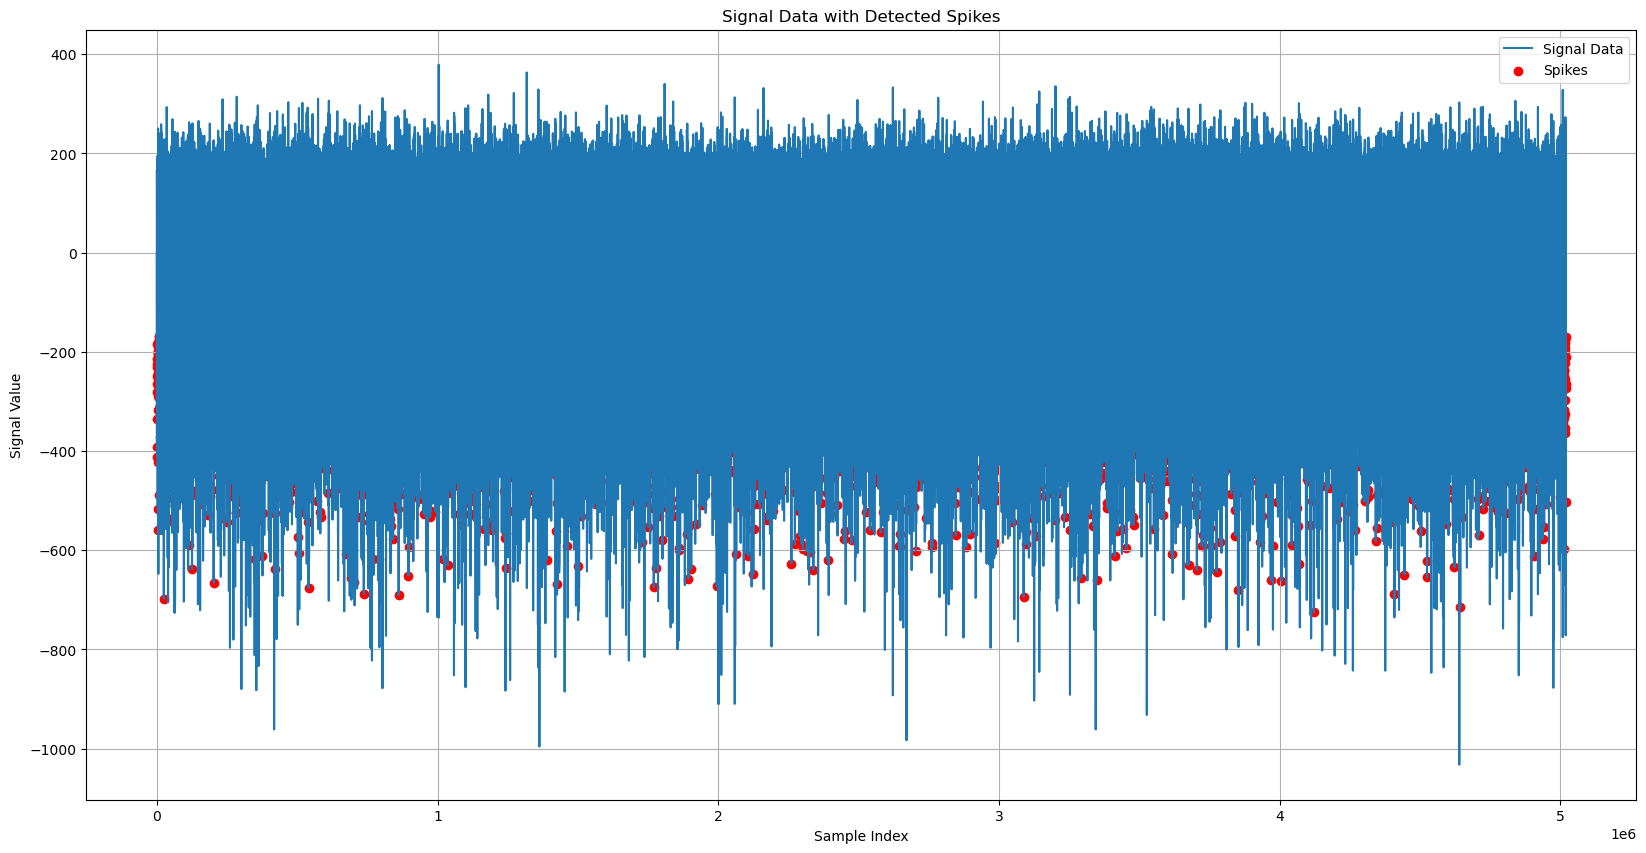

In [95]:
coeff=3
#threshold=(scipy.stats.median_abs_deviation(part,scale='normal'))
plt.figure(figsize=(20, 10))
plt.plot(channel, label='Signal Data')
plt.scatter(all_new1, [channel[i] for i in all_new1], c='red', marker='o', label='Spikes')
#plt.axhline(y=-3*threshold, color='r', linestyle='--', label='3*MAD')
#plt.axhline(y=-4*threshold, color='g', linestyle='--', label='4*MAD')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([6000,12000,-600,300])
plt.savefig('aftercutouts.jpg')
plt.show()

47 overallstd 66.3105785768458 std 201.87783851925863 mean 6.932112671930769 3.044428850598959 128494.3235527593


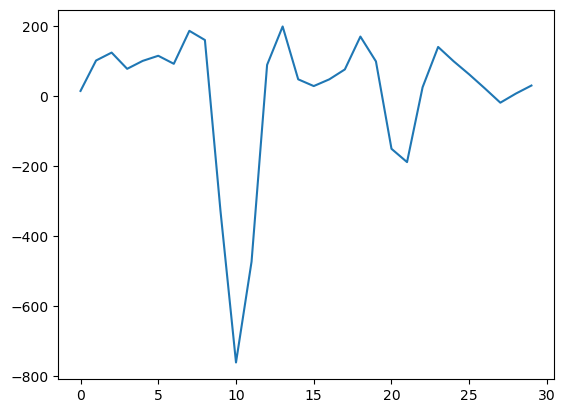

In [78]:
x=randint(0,len(buttati)-1)
spike=buttati[x]
plt.plot(spike)
print(x,'overallstd',np.std(channel),'std',np.std(spike),'mean',np.mean(spike),np.std(spike)/np.std(channel),np.mean(spike)/np.mean(channel))

In [66]:
buttati

array([], shape=(0, 30), dtype=float64)

In [30]:
np.std(spike)/np.std(channel)

2.8731154555211615

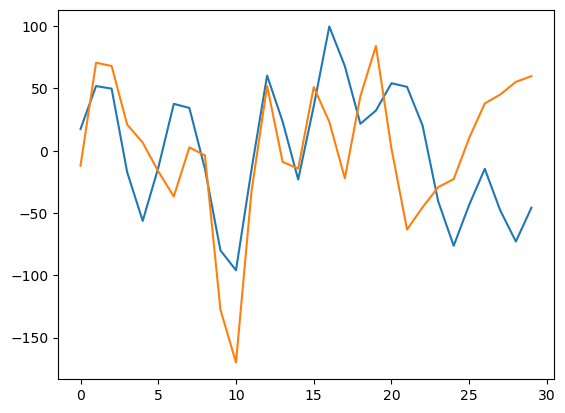

In [23]:
plt.plot(cut_outs1[0])
plt.plot(cut_outs2[0])

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import sklearn.preprocessing as ps
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
from gettext import find
import sys, importlib
from  McsPy.McsData import RawData
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import h5py
import scipy
import pywt
#from tqdm import tqdm
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
import time
from scipy.signal import butter, filtfilt
from scipy import signal



def spike_sorting(input_path,output_path):
    name_data = input_path.split("/")[-1]
    #file reading:
    print('File Reading...')
    data = h5py.File(input_path,'r')
    data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
    info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
    info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
    labels = info_table['Label']
    readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
    fs = 10000 #Sampling Frequency
    print('data shape: ',readings.shape)
    prova=readings.drop([b'Ref'],axis=1)
    #prova=prova.iloc[0:750500, :]
    #prova=prova.iloc[:, :15]
    ref=readings[b'Ref']
    #ref=ref[0:750500]
    freqs, spectrogram = signal.welch(readings[b'Ref'].values, fs=10000, nfft=1024)
    noise_freq = freqs[spectrogram.argmax()]
    Q = 30
    b, a = scipy.signal.iirnotch(noise_freq, Q, fs)
    Q = 60
    b_2, a_2 = scipy.signal.iirnotch(2*noise_freq, Q, fs)
    channel = readings[b'Ref'].values
    pre_filtered_ref = scipy.signal.filtfilt(b, a, channel)
    pre_filtered_ref = scipy.signal.filtfilt(b_2, a_2, pre_filtered_ref) 
    ref=pre_filtered_ref

    #filtering:
    prova_rows = range(prova.shape[0])
    filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
    lowcut = 300
    highcut = 3000
    fs=10000
    order=8
    b,a=butter_bandpass(lowcut,highcut,fs,order=order)
    filt_ref=filtfilt(b,a,ref)
    print('Data Filtering:')
    for x in tqdm(range(prova.shape[1])):
        filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
    for electrode in prova.columns:
        filt_prova[electrode] = filt_prova[electrode] - filt_ref
    prova=filt_prova
    #detection:
    all_ind=[]
    print('Spike Detection: ')
    for i,electrode in enumerate(tqdm(prova.columns)):
        channel=prova[electrode]
        #ind=windowed_spike_detection(channel)
        ind=spike_detection(channel)
        all_ind.append(ind)
    #spike extraction:
    cut_outs=[]
    all_new=[]
    print('Spike extraction: ')
    for i,electrode in enumerate(tqdm(prova.columns)):
        ind=all_ind[i]
        channel=prova[electrode]
        cut_outs1,all_new1=cut_all(ind,channel)
        cut_outs.append(cut_outs1)
        all_new.append(all_new1)    
    # Clustering:
    final_data=[]
    final_firing=[]
    final_firing.append(name_data)
    print('Clustering: ')
    for channel in (tqdm(range(len(cut_outs)))):
        channel_clusters1,final_firing1=clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel])
        final_data.append(channel_clusters1)
        final_firing.append(final_firing1)
    neurons=[]
    for channel in final_data:
        for neuron in channel:
            neurons.append(neuron)
    print(len(neurons),' neurons detected and sorted')
    adj_neur=[]
    counter = 0
    max_len=0
    for neuron in neurons:
        print('counter: ',counter,neuron.shape[0])
        if neuron.shape[0]>max_len:
            max_len=neuron.shape[0]
        counter+=1
    for neuron in neurons:
        if neuron.shape[0]<max_len:
            diff = max_len-neuron.shape[0]
            adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    save_data = 'After'+name_data+'.txt'
    #np.savetxt("/Users/Gaia_1/Desktop/tesi/Data after SS/%s.txt" % save_data,adj_neur, delimiter=', ', fmt='%12.8f')
    np.savetxt(f"{output_path}/{save_data}.txt", adj_neur, delimiter=', ', fmt='%12.8f')

    print('saved: ',save_data)
    return neurons, final_firing
